# Lecture 3. Discovering causal dependencies

For more information follow the following link
* Amit Sharma, Emre Kiciman, et al. [DoWhy](https://github.com/microsoft/dowhy
): A Python package for causal inference. 2019. 

In [ ]:
#@title Installation of DoWhy and other packages {display-mode: "form"}
!pip install dowhy
!apt install libgraphviz-dev
!pip install pygraphviz

     |████████████████████████████████| 123 kB 5.5 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-

In [ ]:
#@title Helper functions {display-mode: "form"}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

#!pip install dowhy
import dowhy
from dowhy import CausalModel
import dowhy.datasets

# Introduction

DoWhy is meant to discover the causal relations between attributes. It is performed into 4 steps:
1. Modeling (create a causal graph to encode assumptions)
2. Identification (formulate what to estimate)
3. Estimation (compute the extimate)
4. Refutation (validate the assumptions)


## 1. Modeling (creating a causal graph to encode assumptions)
DoWhy supports two formats for graph input: `gml` (preferred) and `dot`. The first one is strongly suggested since it works well with networkx. 


There are several pattens that can be found in causal graphs, e.g., chains, forks, colliders.



**Additional notions**:

Confounders: These are variables that cause both the action and the outcome. As a result, any observed correlation between the action and the outcome may simply be due to the confounder variables, and not due to any causal relationship from the action to the outcome.

Instrumental Variables: These are special variables that cause the action, but do not directly affect the outcome. In addition, they are not affected by any variable that affects the outcome. Instrumental variables can help reduce bias, if used in the correct way






## 2. Identify a target estimand under the model

Based on the causal graph, DoWhy finds all possible ways of identifying a desired causal effect based on the graphical model. It uses graph-based criteria and do-calculus to find potential ways find expressions that can identify the causal effect.

The main rules allowing to define whether they are dependent on not are the following:

**Conditional Independence on Chains** Two variables, X and Z, are conditionally independent given Y, if there is only one unidirectional path between X and Z and Y is any set of variables that intercepts that path.

**Conditional Independence in Forks** If a variable X is a common cause of variables Y and Z, and there is only one path between Y and Z, then Y and Z are independent conditional on X.

**Conditional Independence in Colliders** If a variable Z is the collision node between two variables X and Y, and there is only one path between X and Y, then X and Y are unconditionally independent but are dependent conditional on Z and any descendents of Z.

### d-separation

d-separation is a rule allowing to define which nodes are (conditionally) independend in the causal graph.

**d-separation** A path p is blocked by a set of nodes Z, if and only if:
1. p contains a chain of nodes A → B → C, or a fork A ← B → C such that the middle node B *is* in Z, or
2. p is a collider A → B ← C such that the collision node B is *not* in Z, and no descendent of B is in Z.

If Z blocks every path between two nodes X and Y, then X and Y are d-separated, conditional on Z, and thus are independent conditional on Z


Any two nodes X, and Y that are d-separated conditional on Z are necessarily independent conditional on Z.

See details [here](https://medium.data4sci.com/causal-inference-part-vii-d-separation-aa74e361d34e).

**Supported identification criteria**
* Back-door criterion
* Front-door criterion
* Instrumental variables
* Mediation (direct and indirect effect identification)




## 3. Estimate causal effect based on the identified estimand
DoWhy supports methods based on both back-door criterion and instrumental variables. It also provides a non-parametric confidence intervals and a permutation test for testing the statistical significance of obtained estimate.

**Supported estimation methods**

* Methods based on estimating the treatment assignment

The [propensity score](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf) P(T∣C) is the probability that an individual with a given set of background characteristics C will be assigned to a particular treatment group.

Let T be a treatement, and C be a set of background characteristics (observed baseline covariates).


* Propensity-based stratification (`backdoor.propensity_score_stratification`)

Stratification on the propensity score involves stratifying subjects into mutually exclusive subsets based on their estimated propensity score. Subjects are ranked according to their estimated propensity score. Subjects are then stratified into subsets based on previously defined thresholds of the estimated propensity score.
A common approach is to divide subjects into five equal-size groups using the
quintiles of the estimated propensity score. Cochran (1968) demonstrated that
stratifying on the quintiles of a continuous confounding variable eliminated
approximately 90% of the bias due to that variable. 

* Propensity score matching (`backdoor.propensity_score_matching`)

The most common implementation of propensity score matching
is one-to-one or pair matching, in which pairs of treated and untreated subjects are formed, such that matched subjects have similar values of the propensity score.

* Inverse propensity weighting (`backdoor.propensity_score_weighting`)

This is an approach where the treatment outcome model uses sample weights. The weights are defined as the inverse propensity of actually getting the treatment.

Inverse probability of treatment weighting (IPTW) using the propensity score
uses weights based on the propensity score to create a synthetic sample in whichthe distribution of measured baseline covariates is independent of treatment assignment. 

Other methods can be found [here](https://microsoft.github.io/dowhy/#iii-estimate-causal-effect-based-on-the-identified-estimand), e.g., `backdoor.linear_regression`, `backdoor.generalized_linear_model`,  `iv.instrumental_variable`, `iv.regression_discontinuity`.

## 4. Refute the obtained estimate

Having access to multiple refutation methods to validate an effect estimate from a causal estimator is a key benefit of using DoWhy.

**Supported refutation methods**
* Add Random Common Cause: Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)
Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

* Placebo Treatment: What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)
Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

* Dummy Outcome: What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)

* Simulated Outcome: What happens to the estimated causal effect when we replace the dataset with a simulated dataset based on a known data-generating process closest to the given dataset? (Hint: It should match the effect parameter from the data-generating process)

* Add Unobserved Common Causes: How sensitive is the effect estimate when we add an additional common cause (confounder) to the dataset that is correlated with the treatment and the outcome? (Hint: It should not be too sensitive)

* Data Subsets Validation: Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

* Bootstrap Validation: Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)



Submodules
dowhy.causal_refuters.add_unobserved_common_cause module
dowhy.causal_refuters.bootstrap_refuter module
dowhy.causal_refuters.data_subset_refuter module
dowhy.causal_refuters.dummy_outcome_refuter module
dowhy.causal_refuters.placebo_treatment_refuter module
dowhy.causal_refuters.random_common_cause module


Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation


# Example
## Part 1.

We use the dataset from Antonio, Nuno, Ana de Almeida, and Luis Nunes. "Hotel booking demand datasets." [Data in brief 22 (2019): 41-49](https://www.sciencedirect.com/science/article/pii/S2352340918315191), its detailed description is provaided [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md).
Some fragments of the solution are available in the [DoWhy documentation](https://microsoft.github.io/dowhy/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.html).

In [ ]:
# importing dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
# Firstly, we do some preprocessing...

# feature transformation
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices = dataset['reserved_room_type'] != dataset['assigned_room_type']

dataset.loc[slice_indices,'different_room_assigned'] = True
dataset['different_room_assigned'] = dataset['different_room_assigned'].replace(0,False)
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
# Fill missed values 
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])
dataset = dataset.drop(['reservation_status','reservation_status_date',
                        'arrival_date_day_of_month', 'arrival_date_year', 
                        'distribution_channel'],axis=1)
dataset['is_canceled'].replace({0: False, 1: True}, inplace=True)
dataset.dropna(inplace=True)
print(dataset.columns)
dataset.iloc[:, 5:20].head(100)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.00,0,0,0,2.0
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.00,0,0,0,2.0
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.00,0,1,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,73.80,0,1,2,2.0
96,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,117.00,0,1,7,2.0
97,HB,ESP,Offline TA/TO,0,0,0,0,No Deposit,0,Transient,196.54,0,1,7,3.0
98,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,99.30,1,2,7,3.0


In [ ]:
dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  ...  guests  different_room_assigned
deposit_type is_canceled                    ...                                 
No Deposit   False        74947      74947  ...   74947                    74947
             True         29690      29690  ...   29690                    29690

[2 rows x 19 columns]

In [ ]:
dataset_copy = dataset.copy(deep=True)

##  Model 1. No background knowledge

### Step 1. Modeling a causal graph


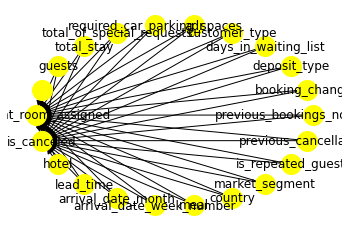

In [ ]:
xs = ""
for i in ['hotel', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests']:
    xs += (str(i)+"+")

model=CausalModel(
        data = dataset,
        treatment='different_room_assigned',
        outcome='is_canceled',
        common_causes=xs.split('+')
        )

model.view_model()

### Step 2. Identification (formulating what to estimate)

In [ ]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|required_car_parking_spaces
d[different_room_assigned]                                                    

                                                                              
,hotel,meal,market_segment,deposit_type,total_of_special_requests,is_repeated_
                                                                              

                                                                              
guest,customer_type,country,arrival_date_week_number,adr,guests,arrival_date_m
                                                                              

                                                                              
onth,booking_changes,days_in_waiting_list,previous_cancellations,previous_book
                                

### Step 3. Estimation (compute the extimate)

In [ ]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|required_car_parking_spaces
d[different_room_assigned]                                                    

                                                                              
,hotel,meal,market_segment,deposit_type,total_of_special_requests,is_repeated_
                                                                              

                                                                              
guest,customer_type,country,arrival_date_week_number,adr,guests,arrival_date_m
                                                                              

                                                                              
onth,booking_changes,days_in_waiting_list,previous_cancellation

### Step 4. Refutation

The causal part came from our assumptions, but not from the dataset. The dataset is used only for statistical estimation. In the ``refutation'' step we  verify whether our assumptions were even correct in the first step or not.

In [ ]:
# Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-0.24464613911871477
New effect:-0.24349648558541698



## Part 2

In [ ]:
import pygraphviz

In [ ]:
# Setting a causal graph
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->different_room_assigned; U->is_canceled;U->required_car_parking_spaces;
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->is_canceled;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> is_canceled;
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> is_canceled;
country->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
}"""

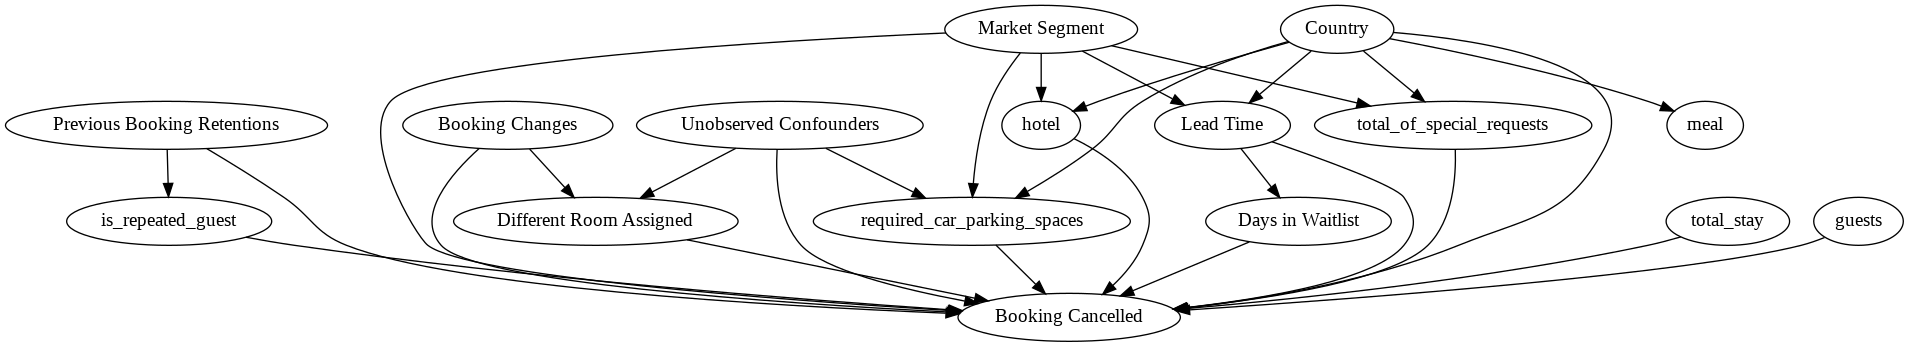

In [ ]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [ ]:
import statsmodels
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|guests,required_car_parking
d[different_room_assigned]                                                    

                                                                              
_spaces,hotel,meal,market_segment,booking_changes,total_of_special_requests,is
                                                                              

                                                                              
_repeated_guest,days_in_waiting_list,country,previous_bookings_not_canceled,to
                                                                              

                    
tal_stay,lead_time))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_ass

In [ ]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|guests,required_car_parking
d[different_room_assigned]                                                    

                                                                              
_spaces,hotel,meal,market_segment,booking_changes,total_of_special_requests,is
                                                                              

                                                                              
_repeated_guest,days_in_waiting_list,country,previous_bookings_not_canceled,to
                                                                              

                    
tal_stay,lead_time))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→i

In [ ]:
# Adds randomly drawn covariates to data and re-runs the analysis to see if the 
# causal estimate changes or not. If our assumption was originally correct then 
# the causal estimate shouldn’t change by much.
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-0.2506950026463798
New effect:-0.24910650506163418



In [ ]:
#Randomly assigns any covariate as a treatment and re-runs the analysis. If our 
# assumptions were correct then this newly found out estimate should go to 0.
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.2506950026463798
New effect:0.0007877775956230182
p value:0.38



In [ ]:
#Creates subsets of the data(similar to cross-validation) and checks whether the 
# causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.2506950026463798
New effect:-0.2493085085427251
p value:0.21

